Context
* I want to select samples from a population given some selection criteria 

Question
* How to take into account measurement uncertainty during sample selection?

My answer
* Evaluate the cdf of each sample at specified limits and take only samples that satisfy the criteria

In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import uniform, norm
import matplotlib.pyplot as pl
from astropy.visualization import hist
import warnings

warnings.simplefilter("ignore")    
pl.style.use('fivethirtyeight')

## Create mock measurements

First, simulate measurements of a parameter $x$ of the population within the domain [$A$, $B$]. Assuming $x$ is uniformly distributed, then

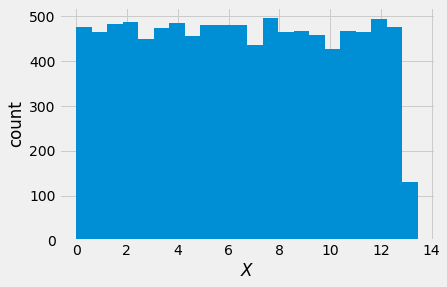

In [2]:
A, B = 0, 13
nsamples = int(1e4)

X = uniform.rvs(loc=A, scale=B, size=nsamples)

#plot histogram using scott binning
bin_method='scott'
hist(X, bins=bin_method);
pl.xlabel("$X$"); pl.ylabel('count');

## Naive sample selection

To select a sample of $X$, a selection criteria is used usually with a set of inequalities. Given a lower and an upper limit ($a,b$), then the sample is obtained with
```
a<X<b : (X>a) & (X<b)
```

For example, using a=4, b=9, then we simply do 

(0, 13)

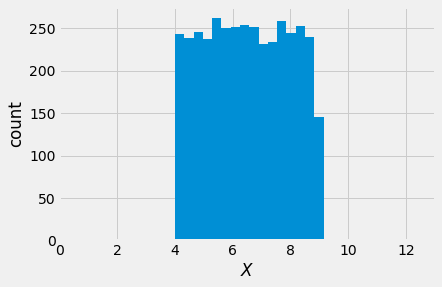

In [3]:
a, b = 4, 9
idx = (X>a) & (X<b)
hist(X[idx], bins=bin_method);
pl.xlabel("$X$"); pl.ylabel('count');
pl.xlim(A, B)

However, in reality, no measurement is exact and hence always have associated uncertainties. If each measurement $x$ has uniform mean and normal uncertainty $\sigma$, then $x$ with $\sigma$=1 would look like

(0, 13)

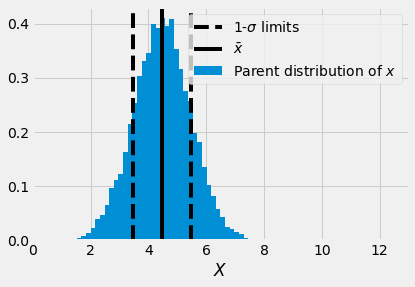

In [4]:
mean = uniform.rvs(loc=A, scale=B) #take x from X
sigma = 1 # uncertainty of x
x = norm.rvs(mean, sigma, size=nsamples)

hist(x, bins=bin_method, label='Parent distribution of $x$', density=True);
pl.axvline(mean-sigma, 0, 1, ls='--', c='k')
pl.axvline(mean+sigma, 0, 1, ls='--', c='k', label=f"{sigma}-$\sigma$ limits")
pl.axvline(mean, 0, 1, ls='-', c='k', label=r'$\bar{x}$')
pl.legend()
pl.xlabel('$X$')
pl.xlim(A, B)

How do we apply our criteria to select a subsample taking into account measurement uncertainties?

To do this, I realized I need to understand cumulative distribution function.

## cumulative distribution function

CDF allows us to compute the probability of drawing a value $\leq x$ from the distribution $X$.

For a standard normal distribution, the cdf evaluated at locations [-1, 0, 1] are:

In [5]:
loc, scale = 0, 1 #standard normal
norm.cdf([-1,0,1], loc=loc, scale=scale)

array([0.15865525, 0.5       , 0.84134475])

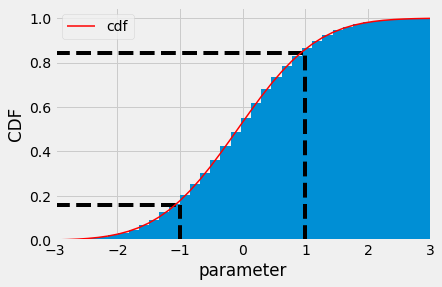

In [6]:
xdist = norm.rvs(0, 1, size=nsamples) 

# plot histogram
n, bins, _ = hist(xdist, bins=bin_method, density=True, cumulative=True);

# add a line showing the expected distribution.
y = ((1 / (np.sqrt(2 * np.pi) * scale)) *
     np.exp(-0.5 * (1 / scale * (bins - loc))**2))
y = y.cumsum()
y /= y[-1]
pl.plot(bins, y, 'r-', linewidth=1.5, label='cdf')

# add locations of interest
xlims = -3, 3
pl.vlines(-scale, 0, norm.cdf(-1), ls='--')
pl.vlines(scale, 0, norm.cdf(1), ls='--')
pl.hlines(norm.cdf(-1), xlims[0], -1, ls='--')
pl.hlines(norm.cdf(1), xlims[0], 1, ls='--')
pl.xlim(*xlims)
pl.xlabel('parameter')
pl.ylabel('CDF')
pl.legend()

## sample selection with uncertainties

Suppose we want to select only those measurements (with uncertainties) that fall between limits $a$, $b$. Then we evaluate the cdf of each limit as if it is drawn from (denoted by ~) the distribution with $N$($x_i,\sigma_i$). 

To get the samples above $a$, then cdf($a$) ~ $N(x_i,\sigma_i)$ < cdf($\sigma$) ~ $N(0,1)$.

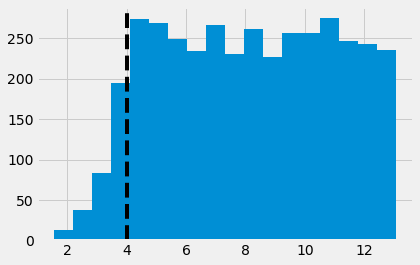

In [7]:
A, B = 0, 13
data_mean = uniform.rvs(loc=A, scale=B, size=nsamples) #mean values of X
data_unc = norm.rvs(0, 1, size=nsamples) #uncertainties of X

sigma=1 # tolerance for x
idx1 = norm.cdf(a, loc=data_mean, scale=data_unc) < norm.cdf(sigma)
hist(data_mean[idx1], bins=bin_method);
pl.axvline(a, 0, 1, ls='--', c='k')

Similarly, to get the samples below $b$, then the cdf($b$) ~ $N(x_i,\sigma_i)$ > cdf($-\sigma$) ~ $N(0,1)$.

(0, 13)

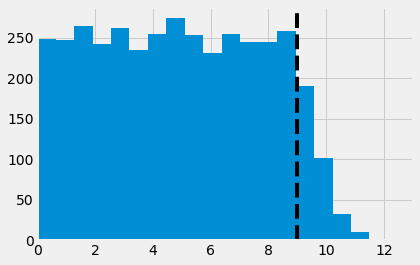

In [8]:
idx2 = norm.cdf(b, loc=data_mean, scale=data_unc) > norm.cdf(-sigma, loc=0, scale=1)
hist(data_mean[idx2], bins=bin_method);
pl.axvline(b, 0, 1, ls='--', c='k')
pl.xlim(A, B)

Combining each criterion becomes

(0, 13)

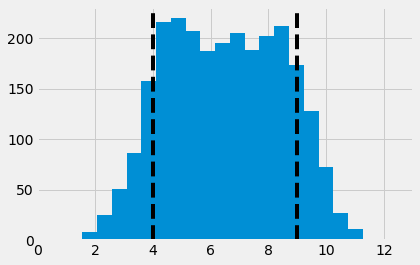

In [9]:
hist(data_mean[idx1 & idx2], bins=bin_method);
pl.axvline(a, 0, 1, ls='--', c='k')
pl.axvline(b, 0, 1, ls='--', c='k')
pl.xlim(A, B)

In the plot above, we see mean measurements slightly outside the limits when uncertainties are taken into account. 

## changing sigma

Increasing/decreasing sigma means loosensing/tightening our constraints when applying the cut.

In [10]:
def plot_cdf(sigma=1, nsamples=int(1e4)):
    x = np.linspace(-2, 2, nsamples)
    y = norm.cdf(x,scale=sigma)
    pl.plot(x, y, ls='-',label=f'sigma={sigma}')

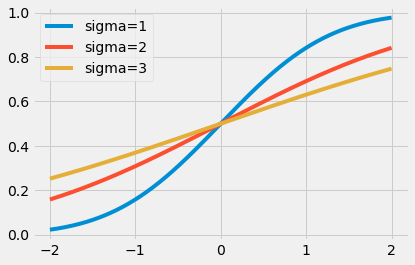

In [11]:
plot_cdf(sigma=1)
plot_cdf(sigma=2)
plot_cdf(sigma=3)
pl.legend()

## Putting it all together

In [12]:
def get_above_lower_limit(lower, data_loc, data_unc, sigma=1):
    idx = (
        norm.cdf(lower, data_loc, data_unc) < norm.cdf(sigma)
        )
    return idx

def get_below_upper_limit(upper, data_loc, data_unc, sigma=1):
    idx = (
        norm.cdf(upper, data_loc, data_unc) > norm.cdf(-sigma)
        )
    return idx

def get_between_limits(lower, upper, data_loc, data_unc, sigma=1):
    idx = (
        get_below_upper_limit(upper, data_loc, data_unc, sigma=sigma) &
        get_above_lower_limit(lower, data_loc, data_unc, sigma=sigma)
        )
    return idx

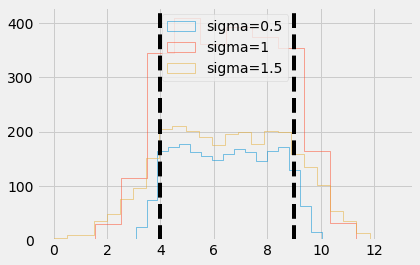

In [13]:
for sigma in [0.5,1,1.5]:
    idx = get_between_limits(a, b, data_mean, data_unc, sigma=sigma)
    hist(data_mean[idx], bins='knuth', histtype='step', label=f'sigma={sigma}');
pl.axvline(a, 0, 1, ls='--', c='k')
pl.axvline(b, 0, 1, ls='--', c='k')
pl.legend();

## Take-aways

Taking into account measurement uncertainties is important during sample selection. This gives flexibility to accept or reject samples near the limits that would otherwise be ignored when naively implementing inequalities. This is especially crucial when there is a gray area near the limits or the choice of threshold is arbitrary. In the real world, this could mean losing a potential discovery or increasing false positives scenarios. Finally, vectorized boolean logic is very powerful and the fact that implementing this very easily in `scipy`is amazing.

If you find any error, please do let me know. You can also download this notebook from [here](https://github.com/jpdeleon/jpdeleon.github.io/blob/master/notebooks/).